# AI502/KSE527, Homework 02

In [1]:
# install dependencies
!pip install ptflops

  Created wheel for ptflops: filename=ptflops-0.6.1-cp36-none-any.whl size=8513 sha256=1f05e9bf8bdc8fceaaeaba4ada6a936b176065fad08f227a2ce89fc0c419e551
  Stored in directory: /root/.cache/pip/wheels/72/9d/42/7047ed6168fbc3d1d3794f2119a7ba032e28df06a5c6db5ea2
Successfully built ptflops


In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms

from torchsummary import summary
from tqdm.auto import tqdm

from ptflops import get_model_complexity_info 
## Reference of ptflops: https://github.com/sovrasov/flops-counter.pytorch

import matplotlib.pyplot as plt

In [3]:
torch.cuda.is_available()

True

# CIFAR100

In [0]:
# Global Variable For training
# You just use the following hyper-parameters
BATCH_SIZE = 128
NUM_EPOCH = 100
LEARNING_RATE = 0.01
CRITERION = nn.CrossEntropyLoss()

In [5]:
# CIFAR10 Dataset
train_dataset = dsets.CIFAR100(root='./data', train=True, 
                              transform=transforms.Compose([
                                            transforms.RandomCrop(32, padding=4),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                        ]), download=True)
test_dataset = dsets.CIFAR100(root='./data', train=False,
                             transform=transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                        ]))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Extracting ./data/cifar-100-python.tar.gz to ./data


# Fit / Eval function

In [0]:
def fit(model, train_loader, test_loader, num_epochs, lr, criterion):
    device = next(model.parameters()).device.index
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    train_loss = []
    test_acc = []
    for epoch in range(num_epochs):

        # train
        losses = []
        model.train()
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            image = data[0].type(torch.FloatTensor).cuda(device)
            label = data[1].type(torch.LongTensor).cuda(device)

            pred_label = model(image)
            loss = criterion(pred_label, label)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

        # test
        model.eval()
        avg_loss = sum(losses)/len(losses)
        train_loss.append(avg_loss)
        acc = eval(model, test_loader)
        test_acc.append(acc)
        print("\tEpoch number: {} - training loss: {} - test accuracy: {}".format(epoch+1, avg_loss, acc))

    return train_loss, test_acc

In [0]:
def eval(model, test_loader):
    model.eval()
    device = next(model.parameters()).device.index
    pred_labels = []
    real_labels = []

    for i, data in enumerate(test_loader):
        image = data[0].type(torch.FloatTensor).cuda(device)
        label = data[1].type(torch.LongTensor).cuda(device)
        real_labels += list(label.cpu().detach().numpy())
        
        pred_label = model(image)
        pred_label = list(pred_label.cpu().detach().numpy())
        pred_labels += pred_label
        
    real_labels = np.array(real_labels)
    pred_labels = np.array(pred_labels)
    pred_labels = pred_labels.argmax(axis=1)
    acc = sum(real_labels==pred_labels)/len(real_labels)*100
    
    return acc

# Construct the 18 layers network

All of PlainNet18, ResNet18, MobileNet18 have same network structure but they are consist of different convolution block (PlainBlock, ResidualBlock, MobileBlock). You have to utilize Net18() when you define the network.

In [0]:
class Net18(nn.Module):
    def __init__(self, block, num_blocks, num_classes):
        super(Net18, self).__init__()
        self.inp = 64
        self.conv0 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn0 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, oup, num_block, stride=1):
        layers = []
        strides = [stride] + [1]*(num_block-1)
        for stride in strides:
            layers.append(block(self.inp, oup, stride))
            self.inp = oup
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.relu(self.bn0(self.conv0(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Task1 : Implement 18-layer CNNs for CIFAR10

In [0]:
class PlainBlock(nn.Module):
    def __init__(self, inp, oup, stride=1):
        super(PlainBlock, self).__init__()
        self.conv0 = nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=True)
        self.bn0 = nn.BatchNorm2d(oup)
        self.rl0 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(oup, oup, kernel_size=3, stride=1, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(oup)
        self.rl1 = nn.ReLU(inplace=True)
        
    def forward(self, x):
        out = self.rl0(self.bn0(self.conv0(x)))
        out = self.rl1(self.bn1(self.conv1(out)))
        return out

# Task2 : Implement ResNet18 for CIFAR10

In [0]:
class ResidualBlock(nn.Module):
    def __init__(self, inp, oup, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv0 = nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=True)
        self.bn0 = nn.BatchNorm2d(oup)
        self.rl0 = nn.ReLU()
        self.conv1 = nn.Conv2d(oup, oup, kernel_size=3, stride=1, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(oup)
        if inp!=oup:
            self.projection = True
            # projection shortcut connection, padding=0
            self.projection_conv = nn.Conv2d(inp, oup, kernel_size=1, stride=stride, bias=True)
        else:
            self.projection = False
        self.rl1 = nn.ReLU()
        
    def forward(self, x):
        out = self.rl0(self.bn0(self.conv0(x)))
        out = self.bn1(self.conv1(out))
        if self.projection==True:
            out += self.projection_conv(x)
        else:
            out += x
        out = self.rl1(out)
        return out

# Task3 : Implement MobileNet for CIFAR10

In [0]:
class MobileBlock(nn.Module):
    def __init__(self, inp, oup, stride=1):
        super(MobileBlock, self).__init__()

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                # 3x3 depthwise convolution
                nn.Conv2d(inp, inp, kernel_size=3, stride=stride, padding=1, groups=inp, bias=True),
                nn.BatchNorm2d(inp),
                nn.ReLU(),
                # 1x1 pointwise convolution
                nn.Conv2d(inp, oup, kernel_size=1, stride=1, bias=True),
                nn.BatchNorm2d(oup),
                nn.ReLU()
            )
        # first layer
        self.layer0 = conv_dw(inp, oup, stride)
        # second layer
        self.layer1 = conv_dw(oup, oup, 1)

    def forward(self, x):
        out = self.layer0(x)
        out = self.layer1(out)
        return out

## Problem 1 : Plot the training loss and test accuracy of 18-layer CNNs for each epoch

In [12]:
# train PlainBlock neural network
plainnet_model = Net18(PlainBlock, [2, 2, 2, 2], 100).cuda()

macs, params = get_model_complexity_info(plainnet_model, (3, 32, 32), as_strings=True, print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))
print("\n")

# train the network
train_loss, test_acc = fit(plainnet_model, train_loader, test_loader, NUM_EPOCH, LEARNING_RATE, CRITERION)


Net18(
  11.05 M, 100.000% Params, 0.551 GMac, 100.000% MACs, 
  (conv0): Conv2d(0.002 M, 0.016% Params, 0.002 GMac, 0.321% MACs, 3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn0): BatchNorm2d(0.0 M, 0.001% Params, 0.0 GMac, 0.024% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(0.0 M, 0.000% Params, 0.0 GMac, 0.012% MACs, inplace=True)
  (layer1): Sequential(
    0.148 M, 1.341% Params, 0.152 GMac, 27.577% MACs, 
    (0): PlainBlock(
      0.074 M, 0.671% Params, 0.076 GMac, 13.789% MACs, 
      (conv0): Conv2d(0.037 M, 0.334% Params, 0.038 GMac, 6.859% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn0): BatchNorm2d(0.0 M, 0.001% Params, 0.0 GMac, 0.024% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rl0): ReLU(0.0 M, 0.000% Params, 0.0 GMac, 0.012% MACs, inplace=True)
      (conv1): Conv2d(0.037 M, 0.334% Params, 0.038 GMac, 6.859% MACs, 64, 64, kernel_size

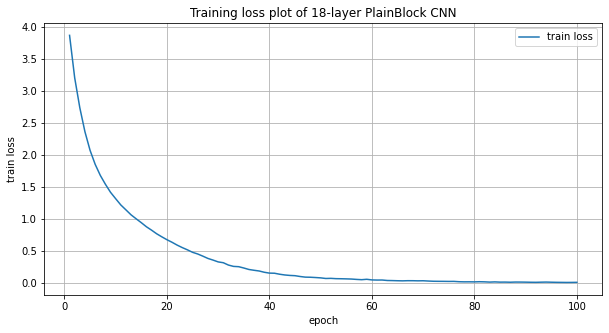

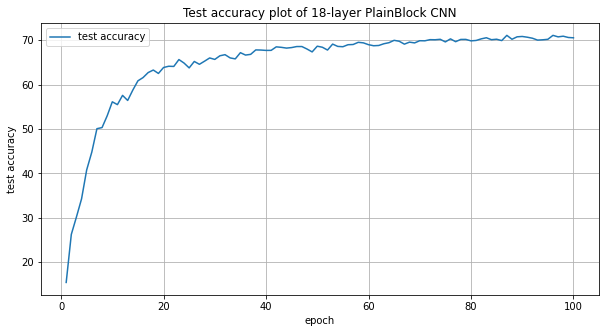

In [17]:
# plot train loss
fig = plt.figure(figsize=(10, 5))
plt.title("Training loss plot of 18-layer PlainBlock CNN")
plt.xlabel("epoch")
plt.ylabel("train loss")
plt.grid()
plt.plot(list(range(1,NUM_EPOCH+1)), train_loss, label="train loss")
plt.legend()
plt.show()

# plot test accuracy
fig = plt.figure(figsize=(10, 5))
plt.title("Test accuracy plot of 18-layer PlainBlock CNN")
plt.xlabel("epoch")
plt.ylabel("test accuracy")
plt.grid()
plt.plot(list(range(1,NUM_EPOCH+1)), test_acc, label="test accuracy")
plt.legend()
plt.show()

## Problem 2: Plot the training loss and test accuracy of ResNet with plotted result of plain network

In [24]:
# train ResidualBlock neural network

resnet_model = Net18(ResidualBlock, [2, 2, 2, 2], 100).cuda()

macs, params = get_model_complexity_info(resnet_model, (3, 32, 32), as_strings=True, print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))
print("\n")
1
res_train_loss, res_test_acc = fit(resnet_model, train_loader, test_loader, NUM_EPOCH, LEARNING_RATE, CRITERION)

Net18(
  11.223 M, 100.000% Params, 0.558 GMac, 100.000% MACs, 
  (conv0): Conv2d(0.002 M, 0.015% Params, 0.002 GMac, 0.317% MACs, 3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn0): BatchNorm2d(0.0 M, 0.001% Params, 0.0 GMac, 0.024% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(0.0 M, 0.000% Params, 0.0 GMac, 0.012% MACs, inplace=True)
  (layer1): Sequential(
    0.148 M, 1.321% Params, 0.152 GMac, 27.263% MACs, 
    (0): ResidualBlock(
      0.074 M, 0.660% Params, 0.076 GMac, 13.632% MACs, 
      (conv0): Conv2d(0.037 M, 0.329% Params, 0.038 GMac, 6.781% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn0): BatchNorm2d(0.0 M, 0.001% Params, 0.0 GMac, 0.024% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rl0): ReLU(0.0 M, 0.000% Params, 0.0 GMac, 0.012% MACs, )
      (conv1): Conv2d(0.037 M, 0.329% Params, 0.038 GMac, 6.781% MACs, 64, 64, kernel_size=(3, 3),

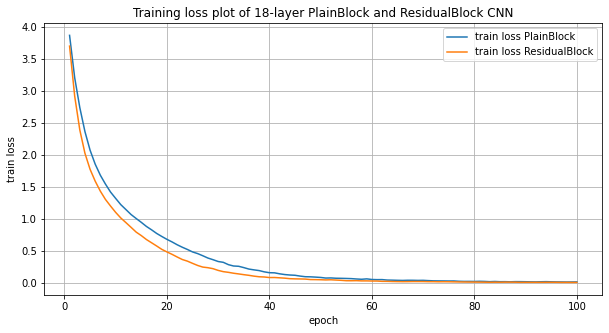

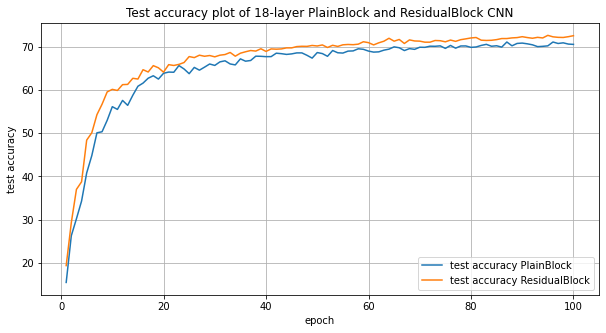

Training loss: [3.8723239618189194, 3.2092640973113076, 2.741701038902068, 2.3666592537594573, 2.0762345476833453, 1.8570059547034066, 1.6843307554874274, 1.5453131583035755, 1.4198471109580506, 1.3202160325501582, 1.222897370453076, 1.1458643022400643, 1.0684382148715845, 1.0061335167311647, 0.9458869206326087, 0.8819745408604517, 0.8290951125457159, 0.7724769005690084, 0.7250180018832312, 0.6799500049532526, 0.6396424011196322, 0.595298510073396, 0.5564989391190317, 0.5215700610214488, 0.4830033913292848, 0.4570018095738443, 0.4233376506877982, 0.38726361271213083, 0.36146732333980863, 0.33312310930103295, 0.3203836419926885, 0.28389189329446124, 0.2628844693646102, 0.2583754609536637, 0.23785676471793743, 0.21475490030196623, 0.20218140237471638, 0.19111748003517576, 0.17130510930133902, 0.1579445044479102, 0.15595374911871102, 0.14048834902513058, 0.1289767482320366, 0.12173675280778914, 0.1176538943882336, 0.10495671885245292, 0.09519147647120764, 0.0933810877030158, 0.08894540342

In [25]:
# plot train loss of PlainBlock and ResidualBlock neural network
fig = plt.figure(figsize=(10, 5))
plt.title("Training loss plot of 18-layer PlainBlock and ResidualBlock CNN")
plt.xlabel("epoch")
plt.ylabel("train loss")
plt.grid()
plt.plot(list(range(1,NUM_EPOCH+1)), train_loss, label="train loss PlainBlock")
plt.plot(list(range(1,NUM_EPOCH+1)), res_train_loss, label="train loss ResidualBlock")
plt.legend()
plt.show()

# plot test accuracy of PlainBlock and ResidualBlock neural network
fig = plt.figure(figsize=(10, 5))
plt.title("Test accuracy plot of 18-layer PlainBlock and ResidualBlock CNN")
plt.xlabel("epoch")
plt.ylabel("test accuracy")
plt.grid()
plt.plot(list(range(1,NUM_EPOCH+1)), test_acc, label="test accuracy PlainBlock")
plt.plot(list(range(1,NUM_EPOCH+1)), res_test_acc, label="test accuracy ResidualBlock")
plt.legend()
plt.show()

print("Training loss: " + str(train_loss))
print("Test accuracy: " + str(test_acc))

## Problem 3

In [31]:
# train MobileBlock neural network

mobilenet_model = Net18(MobileBlock, [2, 2, 2, 2], 100).cuda()

macs, params = get_model_complexity_info(mobilenet_model, (3, 32, 32), as_strings=True, print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))
print("\n")

mob_train_loss, mob_test_acc = fit(mobilenet_model, train_loader, test_loader, NUM_EPOCH, LEARNING_RATE, CRITERION)

Net18(
  1.326 M, 100.000% Params, 0.071 GMac, 100.000% MACs, 
  (conv0): Conv2d(0.002 M, 0.130% Params, 0.002 GMac, 2.499% MACs, 3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn0): BatchNorm2d(0.0 M, 0.010% Params, 0.0 GMac, 0.185% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(0.0 M, 0.000% Params, 0.0 GMac, 0.093% MACs, inplace=True)
  (layer1): Sequential(
    0.02 M, 1.525% Params, 0.021 GMac, 29.984% MACs, 
    (0): MobileBlock(
      0.01 M, 0.763% Params, 0.011 GMac, 14.992% MACs, 
      (layer0): Sequential(
        0.005 M, 0.381% Params, 0.005 GMac, 7.496% MACs, 
        (0): Conv2d(0.001 M, 0.048% Params, 0.001 GMac, 0.925% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
        (1): BatchNorm2d(0.0 M, 0.010% Params, 0.0 GMac, 0.185% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(0.0 M, 0.000% Params, 0.0 GMac, 0.093% MACs, )
        

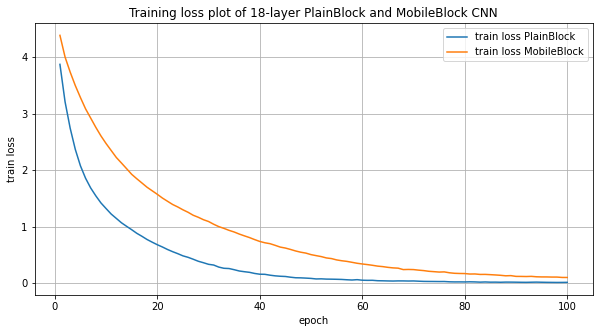

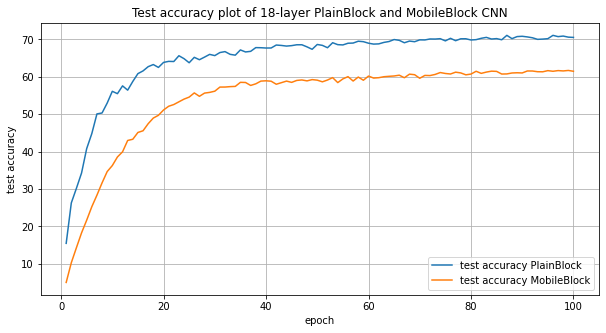

In [32]:
# plot train loss of PlainBlock and MobileBlock neural network
fig = plt.figure(figsize=(10, 5))
plt.title("Training loss plot of 18-layer PlainBlock and MobileBlock CNN")
plt.xlabel("epoch")
plt.ylabel("train loss")
plt.grid()
plt.plot(list(range(1,NUM_EPOCH+1)), train_loss, label="train loss PlainBlock")
plt.plot(list(range(1,NUM_EPOCH+1)), mob_train_loss, label="train loss MobileBlock")
plt.legend()
plt.show()

# plot test accuracy of PlainBlock and MobileBlock neural network
fig = plt.figure(figsize=(10, 5))
plt.title("Test accuracy plot of 18-layer PlainBlock and MobileBlock CNN")
plt.xlabel("epoch")
plt.ylabel("test accuracy")
plt.grid()
plt.plot(list(range(1,NUM_EPOCH+1)), test_acc, label="test accuracy PlainBlock")
plt.plot(list(range(1,NUM_EPOCH+1)), mob_test_acc, label="test accuracy MobileBlock")
plt.legend()
plt.show()